This project attempts to analyze the medical cost dataset that can be used to predict medical charges billed by insurance company for the year. The dataset can be used to deduce various insights and correlations ( if any ) between the bill, gender and smoking/non-smoking individuals.
Based on the dataset, we can attempt to begin our analysis by using Linear Regression algorithm and try to find the best estimators for our response variable - _charges_. As a first step, the project will involve inspecting and cleaning the dataset, then some exploratory data analysis, followed by prediction algorithm. The dataset will be split into training and test dataset. Once trained, the model can be used to perform prediction on the test dataset and verify its efficacy.
The source of data is https://www.kaggle.com/datasets/mirichoi0218/insurance

In [4]:
#import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sns
import statsmodels.api as sm

In [5]:
#load the dataset
df = pd.read_csv('insurance.csv')

In [6]:
# inspect rows, columns and first few rows
print('the input csv has ',df.shape[0],' rows and ', df.shape[1], ' columns')
df.head()

the input csv has  1338  rows and  7  columns


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [7]:
#find null values in the dataset,if any
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

#### the datatset does not contain any null or missing cells.

In [8]:
# explore the data types for all columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [9]:
# explore what are the distinct values for object type columns
for c in ['sex','smoker','region']:
    print(c, df[c].unique())

sex ['female' 'male']
smoker ['yes' 'no']
region ['southwest' 'southeast' 'northwest' 'northeast']


#### the result shows that we don't have any missing or unusual values in the dataset that have object type dataset.

In [10]:
# find out the region for which charges are highest
df.groupby('region')['charges'].sum()

region
northeast    4.343669e+06
northwest    4.035712e+06
southeast    5.363690e+06
southwest    4.012755e+06
Name: charges, dtype: float64

In [11]:
# modify categorical variable to numerical. 
# Encoding male as 0 and female as 1
df['sex'].replace(['male', 'female'],
                        [0, 1], inplace=True)

# encoding non-smoker as 0 and smoker as 1
df['smoker'].replace(['no', 'yes'],
                        [0, 1], inplace=True)

# encoding regions as 1,2,3 and 4
df['region'].replace(['southeast', 'southwest','northeast','northwest'],
                        [1,2,3,4], inplace=True)

In [12]:
# inspect the dataset
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,2,16884.92400
1,18,0,33.770,1,0,1,1725.55230
2,28,0,33.000,3,0,1,4449.46200
3,33,0,22.705,0,0,4,21984.47061
4,32,0,28.880,0,0,4,3866.85520


In [13]:
# the dataset has some clear candidates, like BMI and smoker that may have strong positive correlation with charges. 
# I will now attempt to draw a correlation plot to verify the hypothesis
df.corr()

,age,sex,bmi,children,smoker,region,charges
age,1.000000,0.020856,0.109272,0.042469,-0.025019,0.005212,0.299008
sex,0.020856,1.000000,-0.046371,-0.017163,-0.076185,0.016121,-0.057292
bmi,0.109272,-0.046371,1.000000,0.012759,0.003750,-0.261829,0.198341
children,0.042469,-0.017163,0.012759,1.000000,0.007673,0.019257,0.067998
smoker,-0.025019,-0.076185,0.003750,0.007673,1.000000,-0.053930,0.787251
region,0.005212,0.016121,-0.261829,0.019257,-0.053930,1.000000,-0.056993
charges,0.299008,-0.057292,0.198341,0.067998,0.787251,-0.056993,1.000000


<Axes: >

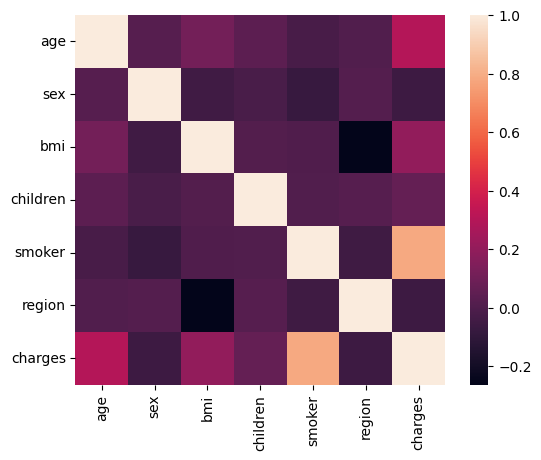

In [14]:
sns.heatmap(df.corr(), square=True)

#### The correlation data above shows there's a high positive correlation between _charges_ and _smoker_ (0.787) and also some correlation with _age_ (0.299)

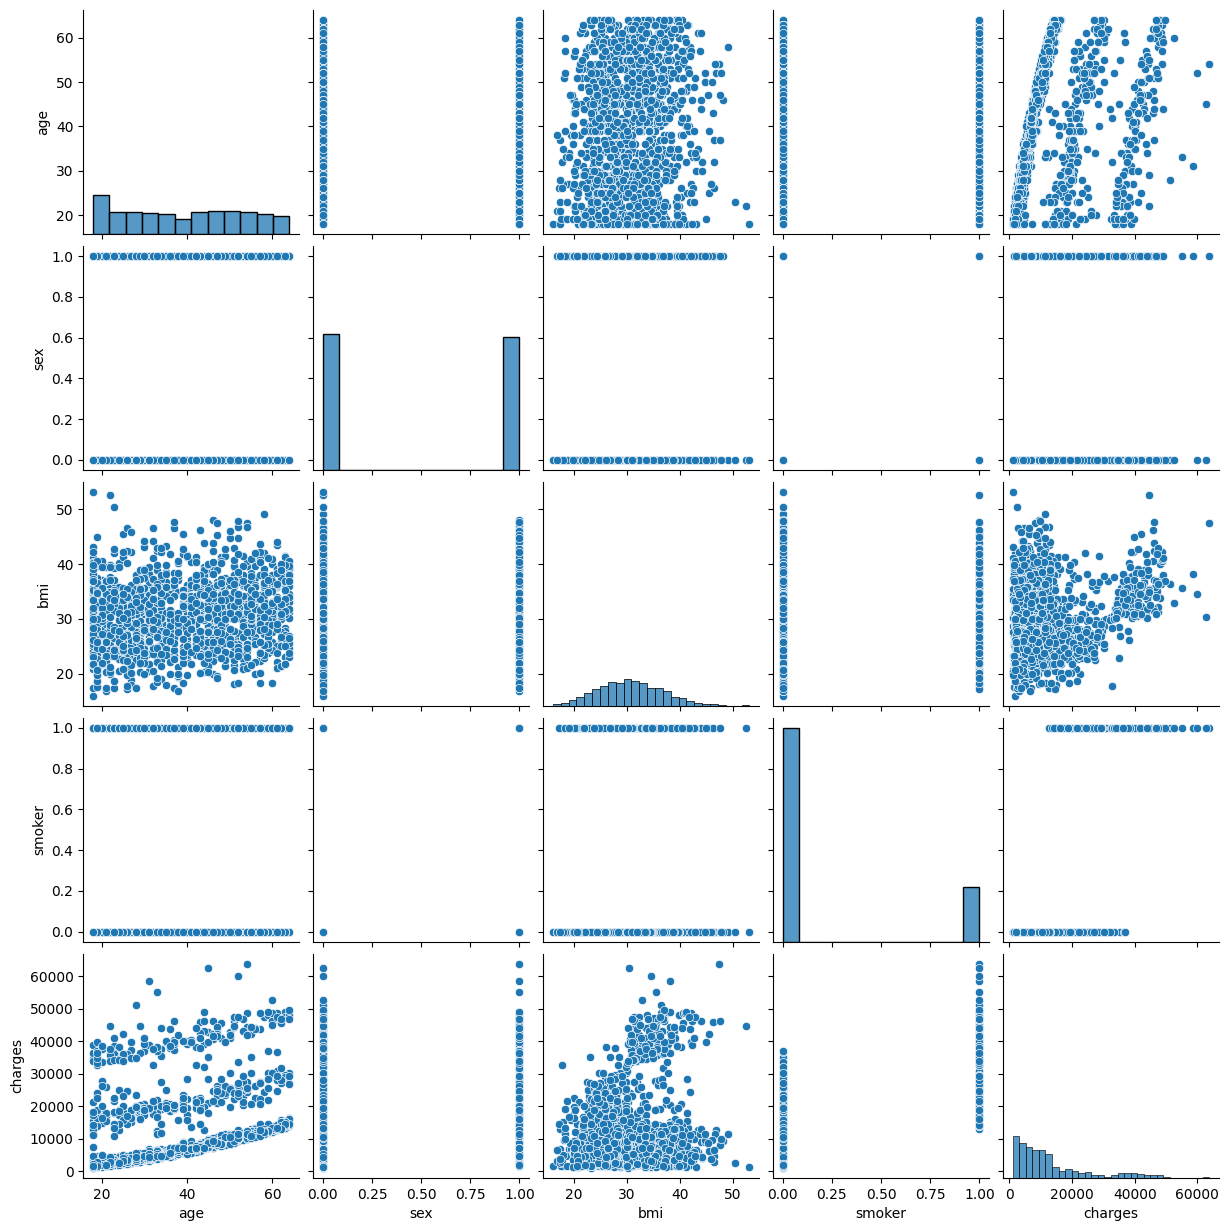

In [15]:
sns.pairplot(df[["age","sex","bmi","smoker", "charges"]])

#### Pair plot between various attributes gives some insight
- It can be seen that with age, the charges increase
- BMI in our sample data has a normal distribution
- For the age range 18-60, BMI is widely spread between 15 to 50+

#### _Smoker_ and _Sex_ attributes are categorical variables so we can do a histogram to get more insight on their association with _charges_

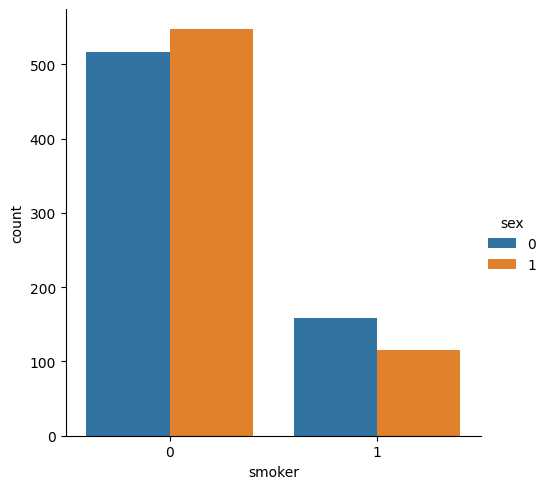

In [16]:
sns.catplot(x="smoker", kind="count",hue = 'sex', data=df)

#### As we can see we have a majority of male smokers. 
#### Now we can use a boxplot or violin plot to see if on average, smoking men have higher _charges_ compared to non-smoking men and women.

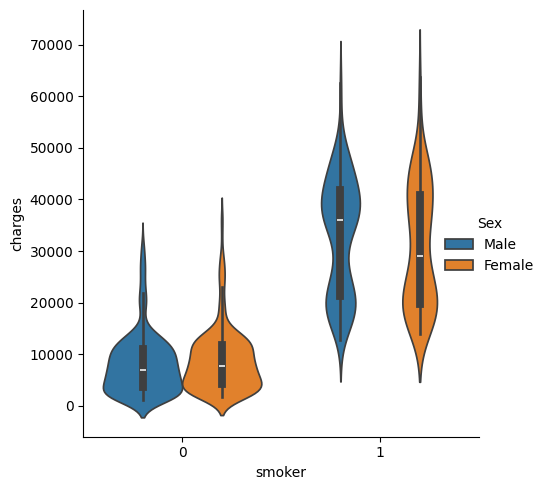

In [76]:
g = sns.catplot(x="smoker", y="charges", hue="sex",kind="violin", data=df)
new_title = 'Sex'
g._legend.set_title(new_title)
new_labels = ['Male', 'Female']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)
pl.show(g)

#### It is clear from the violin plot that smoking men have higher charges on average as compared to other group. Whereas, in the non smoking group, the average charges seem to be same. This can be further validated by running an F test for the model on smoking as a predictor factor with 2 levels and charges as response.

#### Let us now explore the relation between BMI and charges

Text(0.5, 1.0, 'Charges vs BMI')

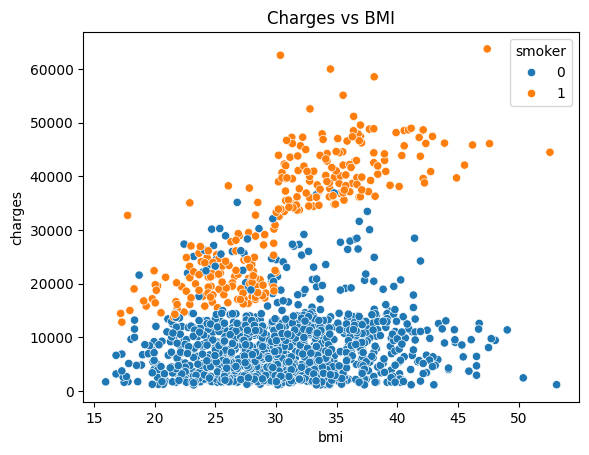

In [127]:
ax = sns.scatterplot(x='bmi',y='charges',data=df, hue='smoker')
ax.set_title('Charges vs BMI')

#### On drawing a scatterplot between _BMI_ vs _Charges_, that people with higher BMI may not necessarily have higher _charges_ but when grouped by _smokers_, it is evident that non smokers pay considerably lesser than smokers for the same BMI

#### Let's try to explore the plot of _charges_ with respect to _age_ between _smokers_ and _non-smokers_ 

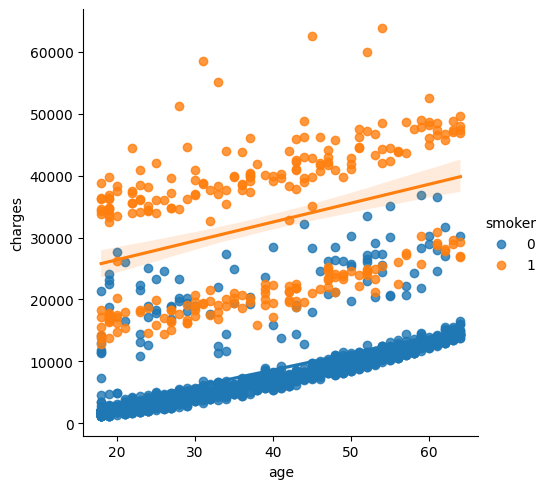

In [123]:
sns.lmplot(x="age", y="charges", hue='smoker', data=df)

#### In non-smokers category, the cost of treatment increases with age. However, in smoking people, we do not see such dependence. We will try to apply linear model and then try to fit multinomial regression on the dataset and see what efficiency we get

In [83]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error
import statsmodels.api as sm

In [106]:
#let's split our data in test and training set into 80:20 ratio.
X = df.drop(['charges','region','age','sex'], axis = 1)
y = df.charges
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

#### Starting with Linear Regression, assuming the significance level alpha = 0.05

In [117]:
# we will use a full model for predicting.
model = sm.OLS(y,X)
reduced_model = model.fit()
print(reduced_model.summary())

# run a prediction on test data
y_pred = reduced_model.predict(x_test)
print("Score for Linear regression on test data:", r2_score(y_test, y_pred))

                                 OLS Regression Results                                
Dep. Variable:                charges   R-squared (uncentered):                   0.844
Model:                            OLS   Adj. R-squared (uncentered):              0.844
Method:                 Least Squares   F-statistic:                              2414.
Date:                Mon, 16 Oct 2023   Prob (F-statistic):                        0.00
Time:                        14:46:45   Log-Likelihood:                         -13761.
No. Observations:                1338   AIC:                                  2.753e+04
Df Residuals:                    1335   BIC:                                  2.754e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [120]:
from scipy.stats import f_oneway

# create full model and run the prediction on test data. 
X_full = df.drop(['charges'], axis = 1)
y_full = df.charges
x_train_full, x_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size=0.2, random_state=2)
model_full = sm.OLS(y_full,X_full)
fitted_model_full = model_full.fit()
print(fitted_model_full.summary())

y_pred_full = fitted_model_full.predict(x_test_full)
print("Score for Linear regression on test data:", r2_score(y_test_full, y_pred_full))

                                 OLS Regression Results                                
Dep. Variable:                charges   R-squared (uncentered):                   0.875
Model:                            OLS   Adj. R-squared (uncentered):              0.874
Method:                 Least Squares   F-statistic:                              1551.
Date:                Mon, 16 Oct 2023   Prob (F-statistic):                        0.00
Time:                        14:47:04   Log-Likelihood:                         -13616.
No. Observations:                1338   AIC:                                  2.724e+04
Df Residuals:                    1332   BIC:                                  2.727e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [119]:
# run the F-test to test Hypothesis - H0: The full model 
f_oneway(y_pred_full, y_pred)

F_onewayResult(statistic=0.014362073287113671, pvalue=0.9046534884274968)

#### After playing with various combination of parameters, I came up with what looks like a suitable set of predictors that helps explain variability in the model. On performing the F test (with H0: Does full model explain all the variability) shows that F-test has high p-value, which causes us to fail to reject null hypothesis and conclude that full model is able to explain the variability better than reduced model.

#### Next I will attempt to apply RandomForest Regressor model on the dataset and test for its efficacy

In [122]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators = 100,
                              criterion = 'squared_error',
                              random_state = 1,
                              n_jobs = -1)

X_rfr = df.drop(['charges'], axis = 1)
y_rfr = df.charges
x_rfr_train, x_rfr_test, y_rfr_train, y_rfr_test = train_test_split(X_rfr, y_rfr, test_size=0.2, random_state=2)

rfr.fit(x_rfr_train,y_rfr_train)
rfr_train_pred = rfr.predict(x_rfr_train)
rfr_test_pred = rfr.predict(x_rfr_test)

print('MSE train data: %.3f, MSE test data: %.3f' % (
mean_squared_error(y_rfr_train,rfr_train_pred),
mean_squared_error(y_rfr_test,rfr_test_pred)))
print('R2 train data: %.3f, R2 test data: %.3f' % (
r2_score(y_rfr_train,rfr_train_pred),
r2_score(y_rfr_test,rfr_test_pred)))

MSE train data: 3246929.803, MSE test data: 24447645.810
R2 train data: 0.978, R2 test data: 0.837


#### We can see that the linear regression full model performs slightly better than Random Forest Regressor model.

### Summary

#### From the above analysis, we can see that 
- There is enough evidence, that male smokers end up paying higher medical charges when compared to non smokers.
- Although increasing BMI does not signify the higher _charges_, but when grouped with _smokers_, we can see a higher medical charges.
- I tried applying a partial and full linear model on the data and the F-statistics reveals that full model is able to explain the variability better than partial model.
- The Random forest regressor is marginally better than Linear Regression model.